In [2]:
import pandas as pd
import numpy as np
import io, re
from unidecode import unidecode
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize

In [3]:
archive = "Corpus.csv"

In [6]:
with open(archive, 'r') as myfile:
    data = myfile.read()
    df = pd.read_csv(io.StringIO(re.sub('"\s*\n','"',data)), delimiter=',')

In [7]:
df.head(10)

,#,Frases,Tipo,Resposta,Ação a ser Realizada,Ações Necessárias
0,1,Ligar luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada,Acender a Lâmpada
1,2,Ligar a luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada,Apagar Lâmpada
2,3,Iluminar o ambiente,Implicito,Deseja acender a lâmpada?,Acender a Lâmpada,Ligar Ventilador
3,4,Já está claro o dia!,Implicito,Apagando a lâmpada.,Apagar Lâmpada,Desligar Ventilador
4,5,Vamos economizar energia?,Implicito,Deseja apagar a lâmpada?,Apagar Lâmpada,Ligar Televisão
5,6,"Casa, apague a luz",Explicito,Apagando a lâmpada.,Apagar Lâmpada,Desligar Televisão
6,7,O ar está muito parado,Implicito,Ligando o ventilador.,Ligar Ventilador,Aumentar Volume
7,8,Está muito quente aqui,Implicito,Ligando o ventilador.,Ligar Ventilador,Diminuir Volume
8,9,Que calor!,Implicito,Deseja ligar o ventilador?,Ligar Ventilador,Mudar Canal
9,10,"Está muito barulho, desligue o ventilador",Explicito,Desligando o ventilador.,Desligar Ventilador,NaN


In [8]:
df = df.drop(columns=['#', 'Ações Necessárias'])

In [9]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [10]:
df['Frases'] = df['Frases'].apply(unidecode)

In [11]:
def replace_i(v):
    return v.replace('í', 'i')

In [12]:
df['Tipo'] = df['Tipo'].apply(replace_i)

In [13]:
df.head(5)

,Frases,Tipo,Resposta,Ação a ser Realizada
0,Ligar luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada
1,Ligar a luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada
2,Iluminar o ambiente,Implicito,Deseja acender a lâmpada?,Acender a Lâmpada
3,Ja esta claro o dia!,Implicito,Apagando a lâmpada.,Apagar Lâmpada
4,Vamos economizar energia?,Implicito,Deseja apagar a lâmpada?,Apagar Lâmpada


In [14]:
X = df['Frases'].tolist()
Y1 = df['Ação a ser Realizada'].tolist()
Y2 = df['Resposta'].tolist()
Y3 = df['Tipo'].tolist()

In [19]:
#Testando somente frases implícitas.
filteredExplicit = df[df.Tipo == 'Explicito']
filteredImplicit = df[df.Tipo == 'Implicito']
X_imp = filteredImplicit['Frases'].tolist()
X_exp = filteredExplicit['Frases'].tolist()
Y1_imp = filteredImplicit['Ação a ser Realizada'].tolist()
Y1_exp = filteredExplicit['Ação a ser Realizada'].tolist()
Y2_imp = filteredImplicit['Resposta'].tolist()
Y2_exp = filteredExplicit['Resposta'].tolist()

In [20]:
# Todas as frases
X = df['Frases'].tolist()
Y1 = df['Ação a ser Realizada'].tolist()
Y2 = df['Resposta'].tolist()
Y3 = df['Tipo'].tolist()

In [21]:
len(set(Y1)), len(set(Y2)), len(set(Y3))

(9, 18, 2)

# preprocessing data

In [ ]:
# !pip install -U scikit-learn

# !pip install gensim

# !pip install nltk

In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y1)

Y1_encoded = le.transform(Y1)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(X)

# using word embeddings

In [30]:
w2v = KeyedVectors.load_word2vec_format('glove_s50.txt')

In [42]:
def transform_w2v(X):
    X_w2v = []
    for sentence in X:
        tokens = word_tokenize(sentence)
        vectors = []
        for token in tokens:
            try:
                vectors.append(w2v.get_vector(token.lower()))
            except:
                print(token)
            
        X_w2v.append(np.mean(vectors, axis=0))
    return X_w2v

X_w2v = transform_w2v(X)

escuridao
ventilacao
friiiiio


In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y1_encoded, test_size=0.25, random_state=42, stratify=Y1_encoded)

# Experiments with classification algorithms

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

In [74]:
params_lr = {'penalty': ['l1', 'l2'], 'C': [0.1, 0.5, 1, 10, 50], 'fit_intercept': [True, False],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr = LogisticRegression()
gs_lr = GridSearchCV(lr, params_lr)
gs_lr.fit(X_train, y_train)

/Users/erickmaziero/.virtualenvs/tcc_guilherme_env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/erickmaziero/.virtualenvs/tcc_guilherme_env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/erickmaziero/.virtualenvs/tcc_guilherme_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/erickmaziero/.virtualenvs/tcc_guilherme_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1, 10, 50],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [78]:
gs_lr.best_params_

{'C': 10, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'newton-cg'}

In [67]:
svm = SVC(random_state=0)
knn9 = KNeighborsClassifier(n_neighbors=9)
tree = tree.DecisionTreeClassifier()
clf = GradientBoostingClassifier()

In [68]:
lr = gs_lr.best_estimator_

svm.fit(X_train, y_train)
knn9.fit(X_train, y_train)
tree.fit(X_train, y_train)
clf.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_knn9 = knn9.predict(X_test)
y_pred_tree = tree.predict(X_test)
y_pred_grad = clf.predict(X_test)

In [47]:
#Accuracy Tests
counter = 0
for it in range(0, len(y_pred_grad)):
    if(y_test[it] == y_pred_grad[it]):
        counter = counter + 1
print(counter/len(y_pred_grad))

0.48936170212765956


['Acender a Lâmpada' 'Apagar Lâmpada' 'Aumentar Volume'
 'Desligar Televisão' 'Desligar Ventilador' 'Diminuir Volume'
 'Ligar Televisão' 'Ligar Ventilador' 'Mudar Canal']


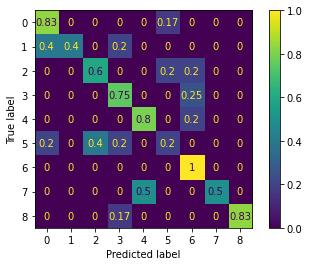

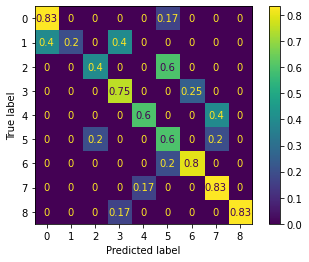

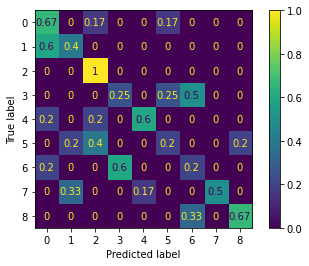

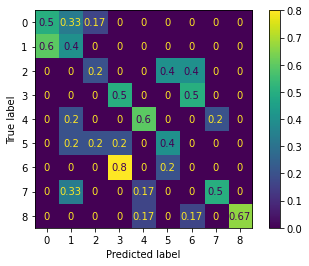

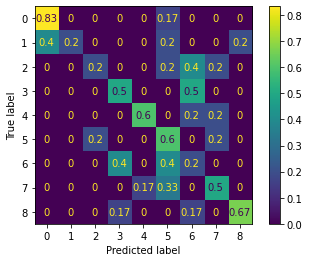

In [69]:
print(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8]))
plot_confusion_matrix(lr, X_test, y_test, normalize='true')
plot_confusion_matrix(svm, X_test, y_test, normalize='true')
plot_confusion_matrix(knn9, X_test, y_test, normalize='true')
plot_confusion_matrix(tree, X_test, y_test, normalize='true')
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

In [70]:
scores_lr = cross_val_score(lr, X_train, y_train, cv=5)
scores_svm = cross_val_score(svm, X_train, y_train, cv=5)
scores_knn9 = cross_val_score(knn9, X_train, y_train, cv=5)
scores_tree = cross_val_score(tree, X_train, y_train, cv=5)
scores_clf = cross_val_score(clf, X_train, y_train, cv=5)

In [71]:
print("LR %0.2f accuracy with a standard deviation of %0.2f" % (scores_lr.mean(), scores_lr.std()))
print("SVM %0.2f accuracy with a standard deviation of %0.2f" % (scores_svm.mean(), scores_svm.std()))
print("KNN %0.2f accuracy with a standard deviation of %0.2f using %d neighbors" % (scores_knn9.mean(), scores_knn9.std(), 9))
print("Tree %0.2f accuracy with a standard deviation of %0.2f " % (scores_tree.mean(), scores_tree.std()))
print("Gradient Boosting %0.2f accuracy with a standard deviation of %0.2f " % (scores_clf.mean(), scores_clf.std()))

LR 0.71 accuracy with a standard deviation of 0.06
SVM 0.67 accuracy with a standard deviation of 0.08
KNN 0.56 accuracy with a standard deviation of 0.07 using 9 neighbors
Tree 0.54 accuracy with a standard deviation of 0.03 
Gradient Boosting 0.64 accuracy with a standard deviation of 0.03 


In [63]:
from sklearn.metrics import classification_report

for i, c in enumerate(list(le.classes_)):
    print(i, c)

In [64]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       1.00      0.40      0.57         5
           2       0.60      0.60      0.60         5
           3       0.50      0.75      0.60         4
           4       0.57      0.80      0.67         5
           5       0.33      0.20      0.25         5
           6       0.62      1.00      0.77         5
           7       1.00      0.50      0.67         6
           8       1.00      0.83      0.91         6

    accuracy                           0.66        47
   macro avg       0.69      0.66      0.64        47
weighted avg       0.71      0.66      0.65        47



In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
print(classification_report(y_test, y_pred_knn9))

In [ ]:
print(classification_report(y_test, y_pred_tree))

In [ ]:
print(classification_report(y_test, y_pred_grad))